# Spark Regression Project

## Import Spark SQL and Pandas Libraries:
Let's import the necessary libraries to create a Spark object.

In [1]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd

## Create Spark Object:
Let's create our Spark object using the builder attribute within the SparkSession class.

We can use this object to view Version, Master, and AppName information.

In [2]:
spark = SparkSession.builder.appName('Dataframe').getOrCreate()

spark

### **Let's read and display our 'California Housing Prices' dataset from the local directory**

**Note:**

If we don't specify inferSchema=True, the CSV file will read all its information as strings.

In [3]:
df = spark.read.option("header", "true").csv("housing.csv", inferSchema=True)

df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

We can use the printschema() method to display the schema of our dataframe and learn the types of our columns.

In [4]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



## Select Numerical and Categorical Columns:
The fact that categorical columns are in string format poses a significant issue for training the model. Therefore, let's write the necessary code to identify numerical columns and categorical columns, enabling us to perform the correct operations on the respective columns.

In [5]:
all_cols = df.columns

num_cols = [c for c, t in df.dtypes if t.startswith("double")]
cat_cols = [c for c, t in df.dtypes if t.startswith("string")]

In [6]:
num_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [7]:
cat_cols

['ocean_proximity']

## Preparation of the Data:
**Encoding:**
* In order to feed categorical columns into the model, we need to convert them into numeric form. For this purpose, we will use OneHotEncoder. There is a significant difference in the usage of OneHotEncoder between PySpark and Scikit-learn. In Scikit-learn, OneHotEncoder takes Object type as input, while in PySpark, it requires numeric type. Therefore, to use OneHotEncoder, we first convert categorical columns to numeric type using StringIndexer, and then apply encoding with OneHotEncoder. Since our dataset has only one categorical column, we can do this in a single step in the pipeline. However, if there are multiple categorical columns, we cannot do it in a single step. For the sake of this project, we will assume as if there are multiple categorical columns in our dataset and adjust the 'stages' parameter of our pipeline accordingly.

**Vector Assembler:**
* we will combine them using vector assembler, since both numerical and categorical columns have numeric types. In PySpark, it is necessary to provide all features as a single column both when applying scaling and training the model.

**Scaling:**
* If we take a quick look at our dataset beforehand, we can observe that it contains negative values, values that do not follow a normal distribution, and outliers. Therefore, to address both negative values, non-normal distribution, and problems caused by outliers, we will use RobustScaler().

**Note:** In this project, since we will use Linear Regression, the model assumes that the variables (data) follow a normal distribution. Another reason we want to use RobustScaler() is for this purpose.

In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, RobustScaler

stages = []
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col + "_encoded"])

stages += [indexer, encoder]

assemblerInputs = [i + "_encoded" for i in cat_cols] + num_cols
vectorAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid="skip")
stages += [vectorAssembler]

robustScaler = RobustScaler(inputCol=vectorAssembler.getOutputCol(), outputCol="scaled_features")
stages += [robustScaler]

### Usage Pipeline and Linear Regression Model:
**Step by Step:**

**1.** We split our dataframe before applying any operations.

**2.** Before providing our training data to the Linear Regression model, we fit the pipeline to instruct it on how to apply the data preprocessing steps by first providing our training data to the pipeline.

**3.** We ensure that the data preprocessing steps are applied to both our train and test data by applying the transform() method to both.

**4.** Finally, we provide the transformed train data to our regression model, allowing the model to learn what the average value of a house might be using the training data.

In [9]:
from pyspark.ml.regression import LinearRegression
# 1
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

# 2
pipeline = Pipeline(stages=stages)
pipeline_transformer = pipeline.fit(train_data)

# 3
valid_train = pipeline_transformer.transform(train_data)
valid_test = pipeline_transformer.transform(test_data)

# 4
MLR = LinearRegression(featuresCol="scaled_features", labelCol="median_house_value")
model = MLR.fit(valid_train)

## Evaluating Model:
We enable our trained model to predict the value of a house using the transformed test data. To achieve this, we utilize the evaluate() method of our regression model.

In [10]:
pred = model.evaluate(valid_test)

As a result of the above process, our pred dataframe will be created. This method essentially writes the predictions onto a column and then concatenates the transformed test data along with this column with axis=0.

In [11]:
pred.predictions.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'ocean_proximity_index',
 'ocean_proximity_encoded',
 'features',
 'scaled_features',
 'prediction']

In [12]:
final_df = pred.predictions.select("prediction", "median_house_value").withColumnRenamed("median_house_value", "Label")

final_df.show()

+------------------+--------+
|        prediction|   Label|
+------------------+--------+
|103599.83321697106|103600.0|
|106699.64996373218|106700.0|
| 73200.00838571694| 73200.0|
| 90099.76027538384| 90100.0|
| 66999.88121587796| 67000.0|
| 86399.91525723398| 86400.0|
| 70499.74951122406| 70500.0|
| 85099.85086416012| 85100.0|
| 80499.76010891488| 80500.0|
| 95999.95616676859| 96000.0|
| 75499.90413798466| 75500.0|
|  74999.8164167832| 75000.0|
|100599.82704075653|100600.0|
| 74099.77088612516| 74100.0|
| 66800.17745011438| 66800.0|
|  72599.8204911168| 72600.0|
| 81099.87053756721| 81100.0|
|135600.44942403585|135600.0|
|119400.15109463451|119400.0|
| 71299.93981479376| 71300.0|
+------------------+--------+
only showing top 20 rows



---

### Evaluate Coefficient:
In regression models, coefficients are calculated to determine the effect of independent variables on the model. These coefficients indicate how much the predicted value of the dependent variable (target) changes when the values of the independent variables (features) change.

In [13]:
coef = model.coefficients

print(f"Coefficient: {coef}")

Coefficient: [-0.013065519103106568,0.14395153924998325,0.0,0.0,-0.9889349750447308,-0.9453620637886726,-0.24297448193678578,0.0718442531150927,0.3687449454560945,-0.2518773487682104,-0.2609487902765698,-0.28852103862244205,144000.20419900282]


---

### Evaluate Intercept:
The intercept indicates how much the regression curve shifts along the y-axis (dependent variable). It shows where the dependent variable starts when the effect of other independent variables is constant. 

**For example,** 

In a linear regression model, it shows where the curve intersects the y-axis.

* A positive intercept means the curve shifts upward along the y-axis.
* A negative intercept shifts the curve downward.

This value plays a significant role in interpreting the model's predictions and understanding the results.

In [14]:
intercept = model.intercept

print(f"Intercept: {intercept}")

Intercept: -21.578460875839042


---

### Visualizing Model Results:
We can visualize the results of our model using the pyplot interface within matplotlib.

<Axes: xlabel='Label', ylabel='prediction'>

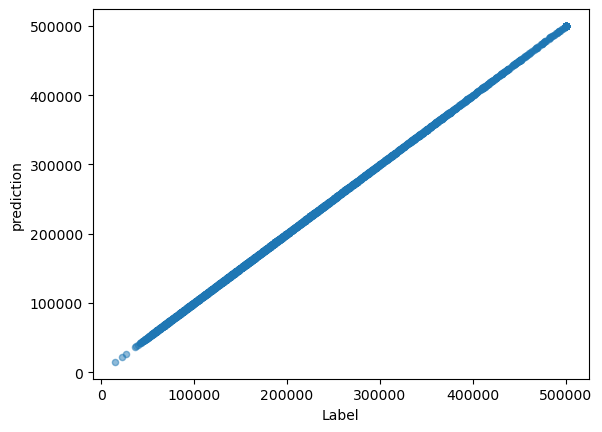

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

final_pd_df = final_df.toPandas()
final_pd_df.plot.scatter(x="Label", y="prediction", alpha=0.5)

---

### Evaluate Root Mean Square Error (RMSE) and R-squared (R^2):
**Root Mean Square Error**:

We use it to measure the variance between predictions and actual values. This RMSE value shows us the average number of values between the predicted house values and the actual house values.

**R-squared:**

It is a statistical measure we use to evaluate the performance of the model in regression analysis. This statistical method allows us to compare different regression models. In fact, this value indicates how strong our regression model is. It has a value between 0 and 1, and the closer this value is to 1, the better our chosen regression model performs.


**Note:** We use the RegressionEvaluator class to perform these statistical operations.

In [16]:
from pyspark.ml.evaluation import RegressionEvaluator
# median_house_value == Label
evaluation = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction")

R2 = evaluation.evaluate(pred.predictions, {evaluation.metricName: "r2"})
rmse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "rmse"})

In [17]:
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 0.32958769845947433


In [18]:
print(f"r2: {R2}")

r2: 0.9999999999921274
